<a href="https://colab.research.google.com/github/ArtuomMerkulov/ArtuomMerkulov/blob/main/%22%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BE%D0%B4%D0%B5%D0%B6%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключение бибилиотек


In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация рук

## Загрузка картинок



In [4]:
!unzip -q '/content/drive/MyDrive/Numpy/fashion.zip' 

In [5]:
img_width = 176
img_height = 240 
num_classes = 31
directory = '/content/fashion/' 
train_directory = 'original' # Название папки с файлами обучающей выборки
val_directory = 'masks' # Название папки с файлами проверочной выборки

### Оригинальные изображения



In [6]:
train_images = [] 
val_images = [] 

cur_time = time.time()
for filename in sorted(os.listdir(directory + train_directory)): 
    train_images.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_images)) 

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory)):                 
    val_images.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))    
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_images)) 

Обучающая выборка загржуена. Время загрузки: 36.15c
Количество изображений:  344
Проверочная выборка загржуена. Время загрузки: 20.03c
Количество изображений:  344


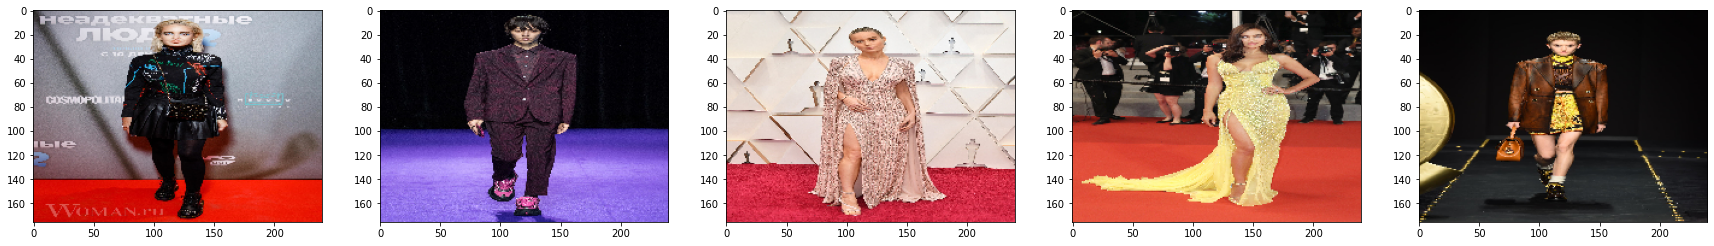

In [7]:
n = 5
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(train_images)
  axs[i].imshow(img) 
plt.show() 

### Сегментированные изображения

In [8]:
train_segments = [] 
val_segments = [] 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory)): 
    train_segments.append(image.load_img(os.path.join(directory + train_directory, filename),
                                       target_size=(img_width, img_height))) 
print('Обучающая выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(train_segments))

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory)):                                                     
    val_segments.append(image.load_img(os.path.join(directory + val_directory, filename), 
                                     target_size=(img_width, img_height)))     
print('Проверочная выборка загржуена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print('Количество изображений: ', len(val_segments))

Обучающая выборка загржуена. Время загрузки: 34.96c
Количество изображений:  344
Проверочная выборка загржуена. Время загрузки: 17.96c
Количество изображений:  344


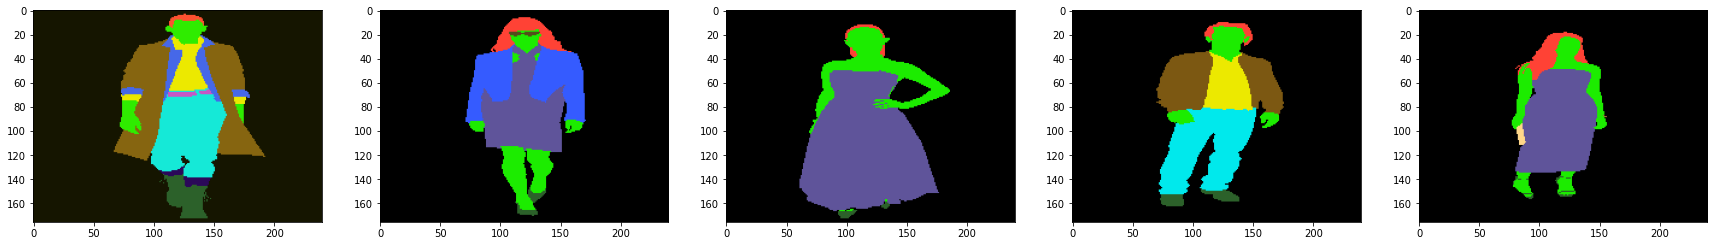

In [9]:
n = 5
fig, axs = plt.subplots(1, n, figsize=(30, 10)) 
for i in range(n):
  img = random.choice(val_segments) 
  axs[i].imshow(img) 
plt.show() 

### Создание выборки



In [10]:
def color2index(color):
    index = -1
    if (51>=color[0]>=0) and (51>=color[1]>=0) and (51>=color[2]>=0) : index=0 # фон
    elif (51>=color[0]>=0) and (251>=color[1]>=51) and (51>=color[2]>=0) : index=1 # кожа
    elif (255>=color[0]>=0) and (101>=color[1]>=0) and (101>=color[2]>=0) : index=2 # волосы
    elif (251>=color[0]>51) and (51>=color[1]>=0) and (149>=color[2]>=51) : index=3 # бабочка
    elif (251>=color[0]>=0) and (251>=color[1]>=0) and (51>=color[2]>=0) : index=4 # мужской верх
    elif (101>=color[0]>=0) and (149>=color[1]>=51) and (255>=color[2]>=0) : index=5 # пиджак
    elif (149>=color[0]>=0) and (249>=color[1]>=0) and (249>=color[2]>=0) : index=6 # штаны
    elif (49>=color[0]>=0) and (149>=color[1]>=51) and (51>=color[2]>=0) : index=7 # обувь
    elif (255>=color[0]>=51) and (255>=color[1]>=0) and (149>=color[2]>=51) : index=8 # сумка
    elif (251>=color[0]>=51) and (149>=color[1]>=51) and (249>=color[2]>=0) : index=9 # шарф
    elif (101>=color[0]>=51) and (101>=color[1]>=51) and (249>=color[2]>=151) : index=10 # платье
    elif (249>=color[0]>=0) and (101>=color[1]>=51) and (249>=color[2]>=151) : index=11 # пояс 
    elif (101>=color[0]>=0) and (149>=color[1]>=51) and (49>=color[2]>=0) : index=12 # очки
    elif (249>=color[0]>=151) and (149>=color[1]>=0) and (255>=color[2]>=0) : index=13 # юбка
    elif (249>=color[0]>=0) and (149>=color[1]>=51) and (149>=color[2]>=51) : index=14 # женский верх
    elif (49>=color[0]>=151) and (149>=color[1]>=0) and (51>=color[2]>=0) : index=15 # головной убор
    elif (149>=color[0]>=101) and (149>=color[1]>=51) and (49>=color[2]>=0) : index=16 # верхняя одежда
    elif (249>=color[0]>=0) and (149>=color[1]>=51) and (149>=color[2]>=101) : index=17 # шорты
    elif (149>=color[0]>=51) and (249>=color[1]>=0) and (249>=color[2]>=151) : index=18 # маска
    elif (51>=color[0]>=0) and (51>=color[1]>=0) and (151>=color[2]>=0) : index=19 # носки
    elif (255>=color[0]>=0) and (255>=color[1]>=0) and (201>=color[2]>=0) : index=20 # перчатки
    elif (251>=color[0]>51) and (251>=color[1]>=0) and (249>=color[2]>=51) : index=21 # часы
    elif (251>=color[0]>=0) and (251>=color[1]>=0) and (51>=color[2]>=0) : index=22 # телефон
    elif (151>=color[0]>=0) and (49>=color[1]>=0) and (255>=color[2]>=0) : index=23 # жилет на пуговицах
    elif (149>=color[0]>=0) and (249>=color[1]>=0) and (149>=color[2]>=0) : index=24 # футболка
    elif (49>=color[0]>=0) and (49>=color[1]>=0) and (51>=color[2]>=0) : index=25 # мужской худи
    elif (155>=color[0]>=0)  and (255>=color[1]>=0) and (249>=color[2]>=51) : index=26 # колготки
    elif (151>=color[0]>=0)  and (49>=color[1]>=0) and (149>=color[2]>=0) : index=27 # комбинезон
    elif (255>=color[0]>=51) and (201>=color[1]>=51) and (49>=color[2]>=0) : index=28 # маникюр
    elif (49>=color[0]>=0) and (255>=color[1]>=51) and (149>=color[2]>=51) : index=29 # нижнее белье 
    else: index=30
    return index  

In [11]:
def index2color(index2):
    index = np.argmax(index2) 
    color = []
    if index == 0: color = [0, 0, 0]      
    elif index == 1: color = [28, 236, 0]  
    elif index == 2: color = [255, 66, 53]  
    elif index == 3: color = [236, 0, 133]
    elif index == 4: color = [236, 233, 0]  
    elif index == 5: color = [53, 91, 255]  
    elif index == 6: color = [0, 233, 236]
    elif index == 7: color = [44, 97, 42]  
    elif index == 8: color = [255, 215, 137]  
    elif index == 9: color = [223, 104, 216]
    elif index == 10: color = [95, 84, 154]  
    elif index == 11: color = [194, 73, 216]  
    elif index == 12: color = [84, 78, 28]
    elif index == 13: color = [237, 86, 255]  
    elif index == 14: color = [221, 75, 275]  
    elif index == 15: color = [47, 138, 120]
    elif index == 16: color = [124, 88, 18]  
    elif index == 17: color = [181, 143, 143]  
    elif index == 18: color = [128, 187, 170]
    elif index == 19: color = [43, 8, 89]  
    elif index == 20: color = [248, 247, 161] 
    elif index == 21: color = [186, 248, 161] 
    elif index == 22: color = [188, 125, 35]
    elif index == 23: color = [128, 34, 155]  
    elif index == 24: color = [62, 169, 127]  
    elif index == 25: color = [24, 45, 41]
    elif index == 26: color = [53, 255, 172]  
    elif index == 27: color = [50, 27, 93]  
    elif index == 28: color = [213, 188, 22]
    elif index == 29: color = [0, 255, 90]  
    elif index == 30: color = [255, 255, 255]

    return color

In [12]:
def rgbToohe(y, num_classes): 
    y_shape = y.shape 
    y = y.reshape(y.shape[0] * y.shape[1], 3) 
    yt = [] 
    for i in range(len(y)): 
      yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) 
    yt = np.array(yt) 
    yt = yt.reshape(y_shape[0], y_shape[1], num_classes) 
    return yt 

In [13]:
def yt_prep(data, num_classes):
    yTrain = [] 
    for seg in data: 
        y = image.img_to_array(seg) 
        y = rgbToohe(y, num_classes)
        yTrain.append(y) 
        if len(yTrain) % 100 == 0: 
            print(len(yTrain)) 
    return np.array(yTrain) 

In [14]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(344, 176, 240, 3)
(344, 176, 240, 3)


In [15]:
cur_time = time.time() 
yTrain = yt_prep(train_segments, num_classes)  
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

100
200
300
Время обработки:  801.18 c


In [16]:
cur_time = time.time() 
yVal = yt_prep(val_segments, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c') 

100
200
300
Время обработки:  414.96 c


In [17]:
yTrain.shape

(344, 176, 240, 31)

In [18]:
yVal.shape

(344, 176, 240, 31)

## Модели


In [19]:
def processImage(model, count = 1, n_classes = 30):
    indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
    fig, axs = plt.subplots(3, count, figsize=(30, 15)) #Создаем полотно из n графиков
    for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
        predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) 
        pr = predict[0] # Берем нулевой элемент из перидкта
        pr1 = [] # Пустой лист под сегментированную картинку из predicta
        pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
        pr = pr.reshape(-1, n_classes) # Решейпим предикт
        yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
        for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
            pr1.append(index2color(pr[k])) # Переводим индекс в писксель
            pr2.append(index2color(yr[k])) # Переводим индекс в писксель
        pr1 = np.array(pr1) # Преобразуем в numpy
        pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        pr2 = np.array(pr2) # Преобразуем в numpy
        pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
        img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
        axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
        axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) 
        axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8')))        
    plt.show()  

### U-net



In [20]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [21]:
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(16, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(128, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(64, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(32, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(32, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(16, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(16, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) 
 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model 

In [22]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) 
history = modelUnet.fit(xTrain, yTrain, epochs=25, batch_size=50, validation_data = (xVal, yVal)) 

Epoch 1/25
7/7 [==============================] - 222s 32s/step - loss: 2.9649 - dice_coef: 0.0664 - val_loss: 3.4043 - val_dice_coef: 0.0457
Epoch 2/25
7/7 [==============================] - 202s 30s/step - loss: 2.0758 - dice_coef: 0.1663 - val_loss: 2.7237 - val_dice_coef: 0.1085
Epoch 3/25
7/7 [==============================] - 198s 29s/step - loss: 1.5283 - dice_coef: 0.2857 - val_loss: 2.0089 - val_dice_coef: 0.2407
Epoch 4/25
7/7 [==============================] - 211s 32s/step - loss: 1.1962 - dice_coef: 0.3987 - val_loss: 1.4417 - val_dice_coef: 0.4281
Epoch 5/25
7/7 [==============================] - 245s 37s/step - loss: 0.9833 - dice_coef: 0.4875 - val_loss: 1.2254 - val_dice_coef: 0.5649
Epoch 6/25
7/7 [==============================] - 206s 30s/step - loss: 0.8333 - dice_coef: 0.5532 - val_loss: 1.1289 - val_dice_coef: 0.5492
Epoch 7/25
7/7 [==============================] - 215s 32s/step - loss: 0.7732 - dice_coef: 0.5898 - val_loss: 1.3010 - val_dice_coef: 0.5507
Epoch 

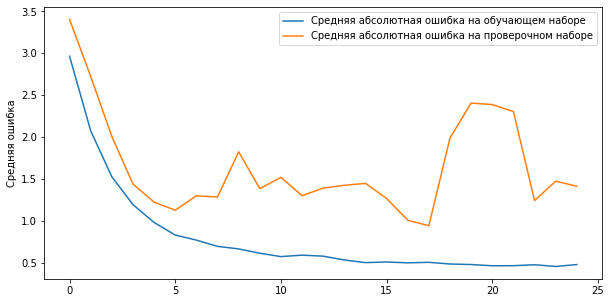

In [23]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [24]:
modelUnet.save_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelUnet.h5')

#### Распознавание



In [25]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) 
modelUnet.load_weights('/content/drive/MyDrive/Модели нейронных алгоритмов/modelUnet.h5')

1/1 [==============================] - 0s 124ms/step


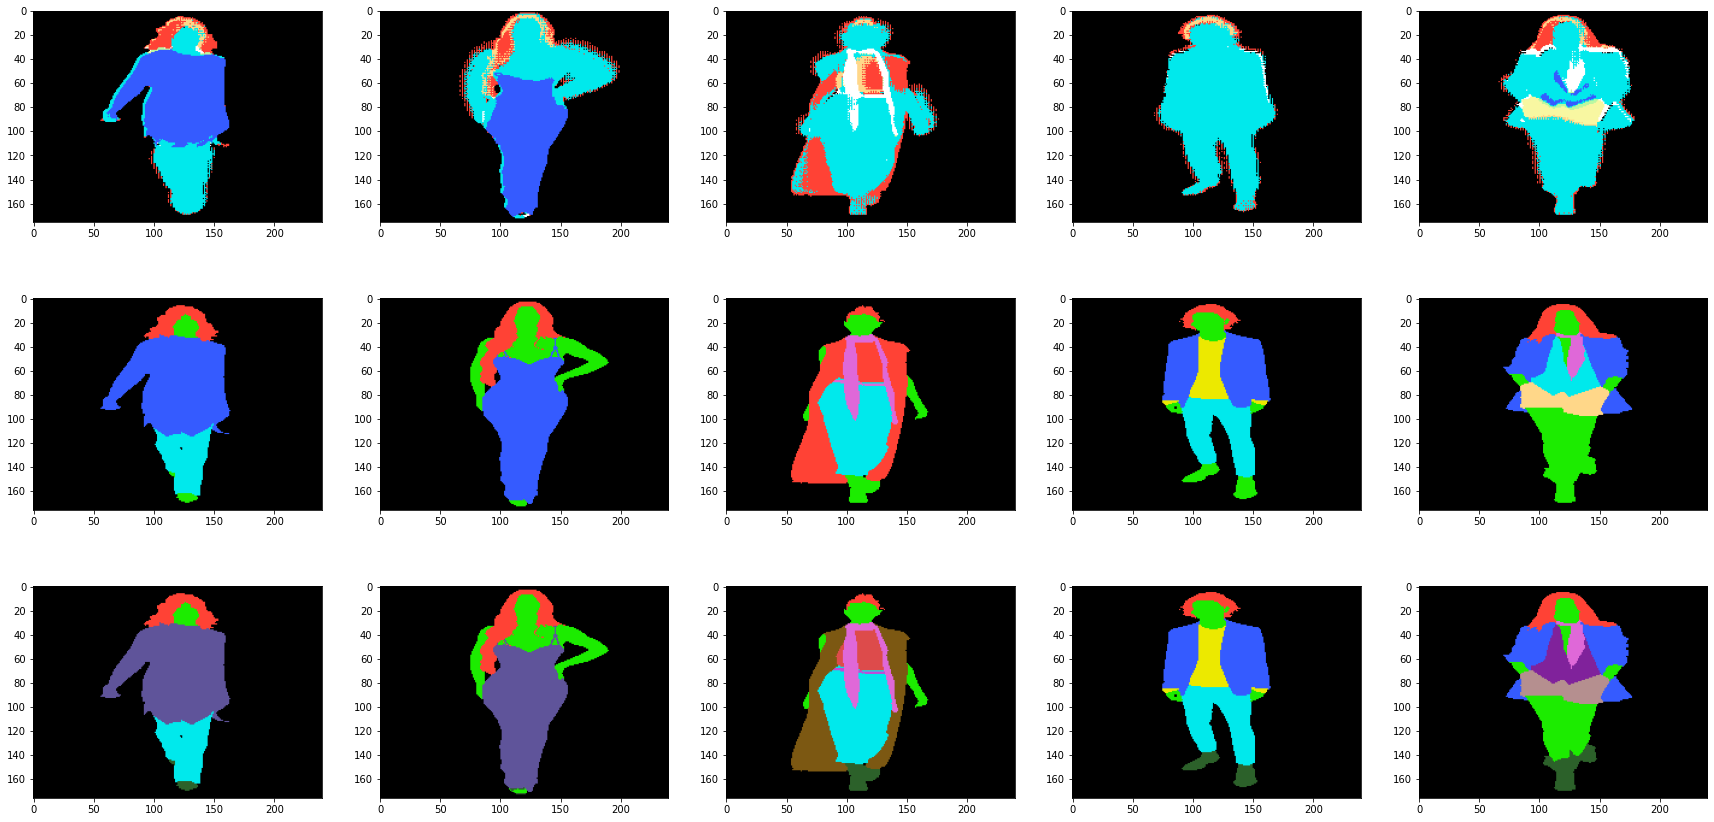

In [26]:
processImage(modelUnet, 5, num_classes)